### Plot seasonal soil moisture elevation/winter-temperature wide
This code plots the soil moisuture for different months at different elevation.
We find
- low temperature corresponds to flat fall/winter soil moisture
- Fall/winter soil moisture get flatter as elevation increases or average winter temperature decreases

The plots created in the code is used in Figure 4 of the manuscript

In [1]:
# #!pip install natsort
# import sys
# sys.path.append('C:/Users/sarfa/AppData/Local/Programs/Python/Python37/Lib/site-packages')

In [46]:
#libraries
import numpy as np
import argparse, os
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import glob
import matplotlib
import time
import pdb

from scipy import stats
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
from natsort import natsorted # 

%matplotlib inline
# matplotlib.use('Agg')

In [47]:
#directories
idir1='D:/Project_soil_moisture/00_SM_project/01_data/'
idir='D:/Project_soil_moisture/00_SM_project/01_data/VIC_outputs_elev_bands_100m'
fig_loc = 'D:/Project_soil_moisture/00_SM_project/04_figure/Figure_04/'

#file name
stafile=idir1+'AvgInfo_ElevBands2.csv'

#read data
df_sta0 = pd.read_csv(stafile)
df_sta = pd.read_csv(stafile)

#date series
date1=np.arange(pd.to_datetime('2000-1-1'),pd.to_datetime('2001-1-01'),timedelta(days=1))

In [4]:
df_sta0.columns

Index(['LatGauge', 'LonGauge', 'GAGEID', 'FittedSlope', 'FittedIntercept',
       'Slope', 'Nov1SM', 'MeanWinterSM', 'TheilSenSlope', 'SpringRunoffVIC',
       'SpringRunoffRatioVIC', 'AvgWinterTemp', 'AvgAnnualTemp', 'PeakSWE',
       'WinterPrecip', 'SpringPrecip', 'PeakSWE_PrecipRatio', 'Apr1SWE',
       'MeanOctSM', 'MeanNovSM', 'MeanDOWYPeakSWE', 'NovTemp', 'DecTemp',
       'JanTemp', 'FebTemp', 'NovSWE', 'DecSWE', 'JanSWE', 'JanSM',
       'TheilSenSlopeSpring', 'SlopeSpring', 'VolSMChangeWint',
       'VolSMChangeSp', 'SM_DOWYPeakSWE', 'VolSMChangeSpringPSWE', 'July31SM',
       'SpringRunoffPSWE_VIC', 'SpringPrecipPSWE', 'WinterPrecipPSWE',
       'SpringEvapPSWE', 'SpringBaseflowPSWE', 'OctPrecip', 'NovPrecip',
       'DecPrecip', 'JanPrecip', 'FebPrecip', 'MarPrecip', 'AprPrecip',
       'MayPrecip', 'JunPrecip', 'JulPrecip', 'Dec1SM', 'Jan1SM', 'Feb1SM',
       'Mar1SM', 'Apr1SM', 'FirstDayBelow0Temp', 'NumbDaysBelow0Temp',
       'MaxConsDaysBelow0Temp', 'FirstDayAbove0Tem

In [20]:
# def read_file(ifile):
#     num_band=int(ifile.split("/")[-1].split("_")[1].split(".")[0])
#     column_names = "Year, Month, Day, PREC, EVAP, RUNOFF, BASEFLOW, AIR_TEMP, SOIL_LIQ1, SOIL_LIQ2, SOIL_LIQ3, SWE".split(", ")
#     df = pd.read_csv(ifile, header=0,sep=',')
#     #df.columns = column_names
#     date2= pd.to_datetime(df.Year*10000+df.Month*100+df.Day, format="%Y%m%d")
#     df['date']=date2
#     df=df.set_index('date',drop=True)
#     df['SOIL_LIQALL']=df.SOIL_LIQ1+df.SOIL_LIQ2+df.SOIL_LIQ3
#     #getdata from 1965-2018
#     df1=df[(df.index >= '1964-10-01') & (df.index<='2018-10-01')]
#     #df1=df['1960':'2015']
#     #print(df1.head())
#     soil_max=df1['SOIL_LIQALL'].max() #find the max soil moisture of this station
#     df1.loc[:,'SOIL_LIQALL_norma']=df1['SOIL_LIQALL']/soil_max #normalize the soil moisture by max sm
#     df_yrmean=df1.groupby([df1.index.month, df1.index.day]).mean()

#     df_yrmean=df_yrmean.set_index(date1)
#     dffinal1=df_yrmean[df_yrmean.Month>=10]
#     dffinal2=df_yrmean[df_yrmean.Month<10]
#     dffinal=dffinal1.append(dffinal2)
#     dffinal['date1']=dffinal.index
#     date2=np.arange(pd.to_datetime('1999-10-1'),pd.to_datetime('2000-10-01'),timedelta(days=1))
#     dffinal=dffinal.set_index(date2)
#     return dffinal,num_band

In [5]:
#load_file load a file for a catachment
staname='Sierra'
list_temp1=os.listdir(idir)
list_temp2=[]
for ista in list_temp1:
    list_temp2.append(ista.split("_")[0])
list_sta=set(list_temp2)

## Function to plot soil moisture with average winter temperature changes

In [159]:
def plot_sm_elev_band(staname):
    file_list=natsorted(glob.glob(idir+ '/' +staname+'*')) #get a file list for different elev bands    
    fontsize=18
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}

    matplotlib.rc('font', **font)
    
    #upper limite of avg winter temperature in degree-C
    n = 10
    
    c = np.arange(-10, n + 1,2)
    norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())

    #color in reverse order to make high temperature red
    cmap_sel = mpl.cm.RdYlBu_r
    cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap = cmap_sel )#cmap=mpl.cm.gray
    cmap.set_array([])
    
    #plot start
    fig = plt.figure(1,figsize=(10,5))
    ax1=fig.add_subplot(111)
    
    dateplot=pd.date_range('1999-10-01',periods=366, freq='D')
    for num_file in range(len(file_list)):
            ifile=file_list[num_file]
            ifile = os.path.abspath(ifile)
            df_in_fa = pd.read_csv(ifile)
            
            st_nm = ifile.split("\\")[-1].split(".")[0]
            num_band = (df_sta0[df_sta0['GAGEID'] == (st_nm)]['AvgWinterTemp'])
            
            df_in_fa1 = df_in_fa[(df_in_fa['Year'] == 1999) & (df_in_fa['Month'] >= 10) ]
            df_in_fa2 = df_in_fa[(df_in_fa['Year'] == 2000) & (df_in_fa['Month'] <= 9) ]

            df_in_fa1 = df_in_fa1.append(pd.DataFrame(data = df_in_fa2), ignore_index=True)
            df_in_fa = df_in_fa1
            df_in_fa['SOIL_LIQALL'] = df_in_fa['SOIL_LIQ1'] + df_in_fa['SOIL_LIQ2'] + df_in_fa['SOIL_LIQ3']
            
            ax1.plot(dateplot,df_in_fa[['SOIL_LIQALL']], '-',lw=.7,label=num_band,c=cmap.to_rgba(int(num_band)))

    ax1.set_ylabel('Soil Moisture (mm)',fontsize=fontsize)
    ax1.set_xticks(np.arange(min(dateplot)+timedelta(15),max(dateplot)-timedelta(10),timedelta(days=30)))
    
    #month labels
    #label="Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep".split(",")
    label="O,N,D,J,F,M,A,M,J,J,A,S".split(",")
    ax1.set_xticklabels( label,)
    ax1.set_xlim(min(dateplot)-timedelta(days=1), max(dateplot)+timedelta(days=1) )

    ticks1=np.arange(-10, n + 1,2)
    cbar=fig.colorbar(cmap, ticks=ticks1)
    ticks_label=ticks1 #[str(i*100) for i in ticks1]
    
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar.ax.set_yticklabels(ticks_label)  # vertically oriented colorbar
    cbar.set_label('Avg. Winter T (℃)')
    
    plt.show();
    fig.savefig(fig_loc+'elev_band_SM_'+staname+'.png',dpi=300)
    plt.clf()

11523200


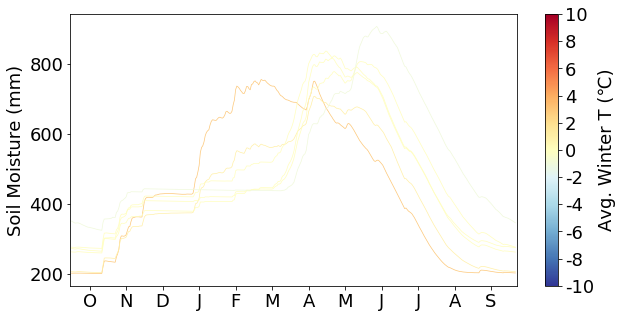

11311900


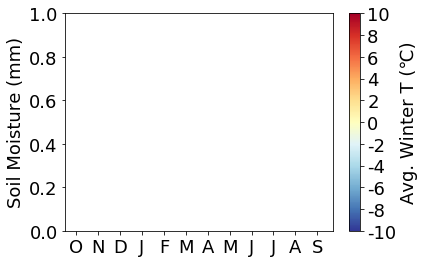

9217900


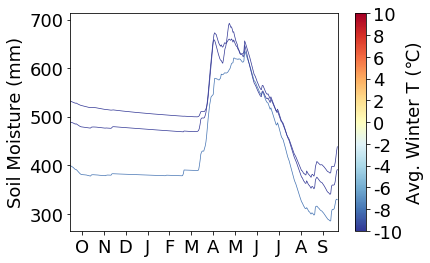

11381500


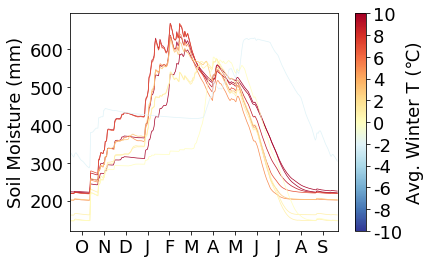

Sierra Nevada


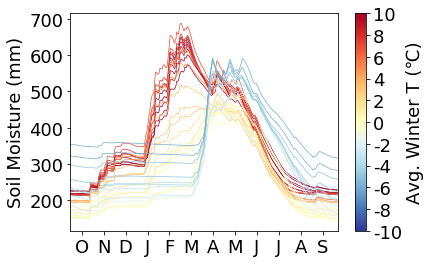

Upper Colorado Region


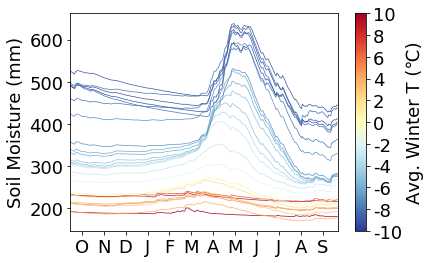

11473900


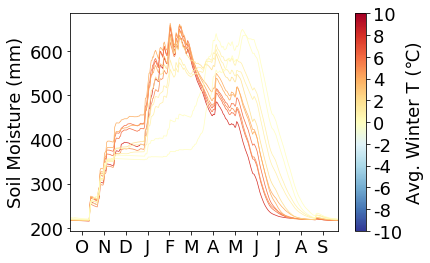

wrong_sta []


<Figure size 432x288 with 0 Axes>

In [10]:
list_sta2 = {'9217900','11473900','11523200','11381500','11311900','Sierra Nevada','Upper Colorado Region'}
wrong_sta=[]
for ista in list_sta2:
    print (ista)
    try:
        plot_sm_elev_band(ista)
    except:
        wrong_sta.append(ista)
print("wrong_sta",wrong_sta)    
    

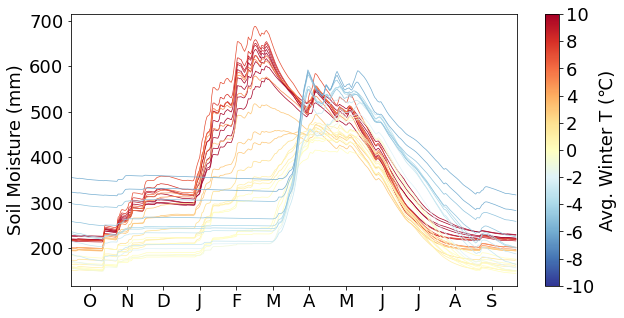

<Figure size 432x288 with 0 Axes>

In [160]:
plot_sm_elev_band('Sierra Nevada')

### Function to plot seasonal soil moisture with average winter temperature, while days of peak SWE and snow disappearance plotted

In [9]:
def plot_sm_elev_band2(staname):
    file_list=natsorted(glob.glob(idir+ '/' +staname+'*')) #get a file list for different elev bands    
    fontsize=18
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}

    matplotlib.rc('font', **font)
    
    #upper limite of avg winter temperature in degree-C
    n = 10
    
    c = np.arange(-10, n + 1,2)
    norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())

    #color in reverse order to make high temperature red
    cmap_sel = mpl.cm.RdYlBu_r
    cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap = cmap_sel )#cmap=mpl.cm.gray
    cmap.set_array([])
    
    #plot start
    fig = plt.figure(1,figsize=(10,5))
    ax1=fig.add_subplot(111)
    
    dateplot=pd.date_range('1999-10-01',periods=366, freq='D')
    
    for num_file in range(len(file_list)):
            ifile=file_list[num_file]
            ifile = os.path.abspath(ifile)
            df_in_fa = pd.read_csv(ifile)
            
            st_nm = ifile.split("\\")[-1].split(".")[0]
            num_band = (df_sta0[df_sta0['GAGEID'] == (st_nm)]['AvgWinterTemp'])
            
            df_in_fa1 = df_in_fa[(df_in_fa['Year'] == 1999) & (df_in_fa['Month'] >= 10) ]
            df_in_fa2 = df_in_fa[(df_in_fa['Year'] == 2000) & (df_in_fa['Month'] <= 9) ]

            df_in_fa1 = df_in_fa1.append(pd.DataFrame(data = df_in_fa2), ignore_index=True)
            df_in_fa = df_in_fa1
            df_in_fa['SOIL_LIQALL'] = df_in_fa['SOIL_LIQ1'] + df_in_fa['SOIL_LIQ2'] + df_in_fa['SOIL_LIQ3']
            sm_all = df_in_fa[['SOIL_LIQALL']]
            
            # Separating day of snow out and day of peak swe
            st_nm2 = ifile.split("\\")[-1].split("_")[0]
            df_tmp = df_sta0[df_sta0['Gage']== st_nm2]
            df_tmp = df_tmp.sort_values(by='Elev_band')
            df_tmp.columns
            el = df_tmp[['MeanDOWYPeakSWE.1','Snowout.1','Elev_band']] #elev_band
            peak_sw_dy = el.iloc[num_file,0]
            peak_sw_dy_sm = sm_all.iloc[peak_sw_dy,0]
            peak_sw_dy = dateplot[peak_sw_dy]
            
            snowout_dy = el.iloc[num_file,1]
            snowout_dy_sm = sm_all.iloc[snowout_dy,0]
            snowout_dy = dateplot[snowout_dy]
            
            
            ax1.plot(dateplot,df_in_fa[['SOIL_LIQALL']], '-',lw=.7,label=num_band,c=cmap.to_rgba(int(num_band)))
            ax1.plot(peak_sw_dy,peak_sw_dy_sm, 'o',c=cmap.to_rgba(int(num_band)), markeredgecolor = 'k')
            ax1.plot(snowout_dy,snowout_dy_sm, 's',c=cmap.to_rgba(int(num_band)), markeredgecolor = 'k')

    ax1.set_ylabel('Soil Moisture (mm)',fontsize=fontsize)
    ax1.set_xticks(np.arange(min(dateplot)+timedelta(15),max(dateplot)-timedelta(10),timedelta(days=30)))
    
    #month labels
    #label="Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep".split(",")
    label="O,N,D,J,F,M,A,M,J,J,A,S".split(",")
    ax1.set_xticklabels( label,)
    ax1.set_xlim(min(dateplot)-timedelta(days=1), max(dateplot)+timedelta(days=1) )

    ticks1=np.arange(-10, n + 1,2)
    cbar=fig.colorbar(cmap, ticks=ticks1)
    ticks_label=ticks1 #[str(i*100) for i in ticks1]
    
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar.ax.set_yticklabels(ticks_label)  # vertically oriented colorbar
    cbar.set_label('Avg. Winter T (℃)')
    
    plt.show();
    fig.savefig(fig_loc+'wint_T_SM_'+staname+'.png',dpi=300)
    plt.clf()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


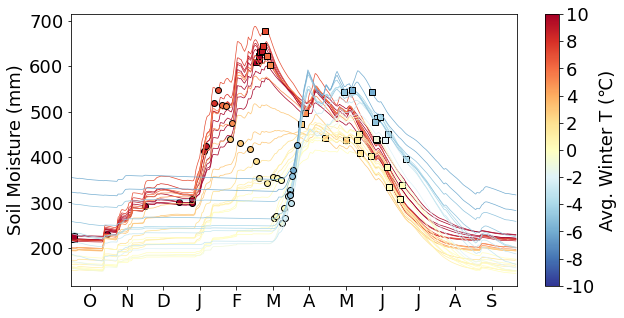

<Figure size 432x288 with 0 Axes>

In [7]:
plot_sm_elev_band2('Sierra Nevada')

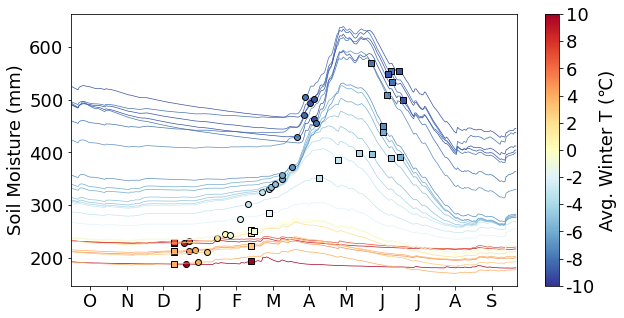

<Figure size 432x288 with 0 Axes>

In [8]:
plot_sm_elev_band2('Upper Colorado Region')

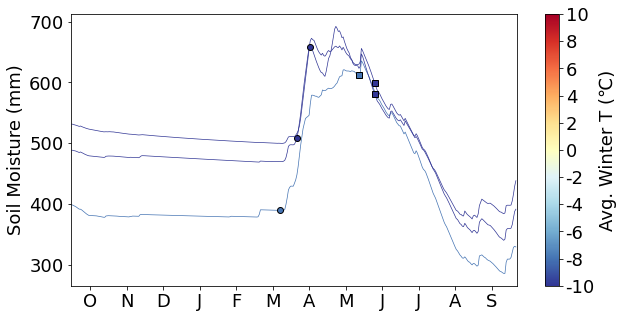

<Figure size 432x288 with 0 Axes>

In [202]:
plot_sm_elev_band2('9217900')

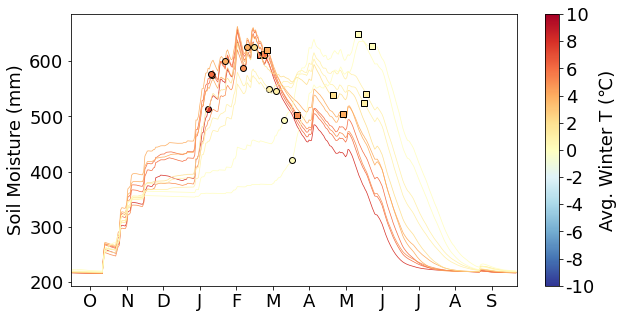

<Figure size 432x288 with 0 Axes>

In [203]:
plot_sm_elev_band2('11473900')

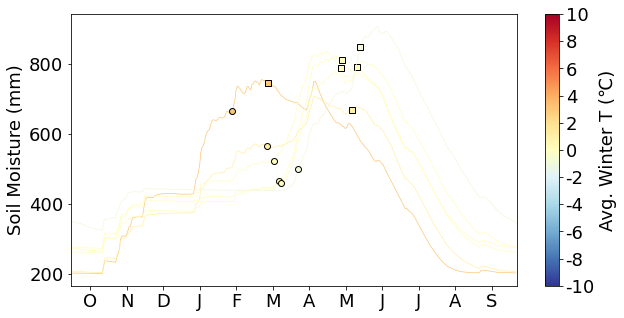

<Figure size 432x288 with 0 Axes>

In [204]:
plot_sm_elev_band2('11523200')

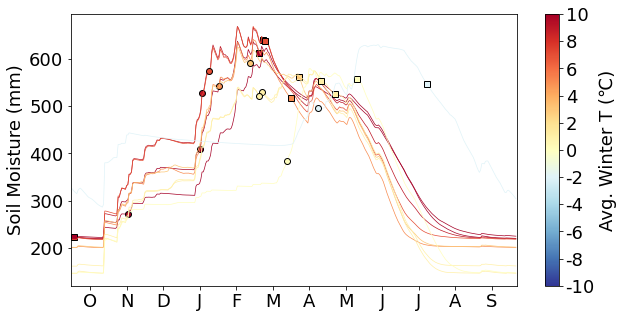

<Figure size 432x288 with 0 Axes>

In [205]:
plot_sm_elev_band2('11381500')

## Plot soil moisture according to elevation [m]

In [49]:
def plot_sm_elev_band3(staname):
    file_list=natsorted(glob.glob(idir+ '/' +staname+'*')) #get a file list for different elev bands    
    fontsize=18
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}

    matplotlib.rc('font', **font)
    
    #upper limite of avg winter temperature in degree-C
    n = 3500
    
    c = np.arange(0, n + 1,500)
    norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())

    #color in reverse order to make high temperature red
    cmap_sel = mpl.cm.RdYlBu
    cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap = cmap_sel )#cmap=mpl.cm.gray
    cmap.set_array([])
    
    #plot start
    fig = plt.figure(1,figsize=(10,5))
    ax1=fig.add_subplot(111)
    
    dateplot=pd.date_range('1999-10-01',periods=366, freq='D')
    
    df_sta0_2 = pd.read_csv(stafile)
    df_sta0_2['Elev_band'] = df_sta0_2['Elev_band']*100-50 
    
    for num_file in range(len(file_list)):
            ifile=file_list[num_file]
            ifile = os.path.abspath(ifile)
            df_in_fa = pd.read_csv(ifile)
            
            st_nm = ifile.split("\\")[-1].split(".")[0]
            num_band = (df_sta0_2[df_sta0_2['GAGEID'] == (st_nm)]['Elev_band'])
            
            df_in_fa1 = df_in_fa[(df_in_fa['Year'] == 1999) & (df_in_fa['Month'] >= 10) ]
            df_in_fa2 = df_in_fa[(df_in_fa['Year'] == 2000) & (df_in_fa['Month'] <= 9) ]

            df_in_fa1 = df_in_fa1.append(pd.DataFrame(data = df_in_fa2), ignore_index=True)
            df_in_fa = df_in_fa1
            df_in_fa['SOIL_LIQALL'] = df_in_fa['SOIL_LIQ1'] + df_in_fa['SOIL_LIQ2'] + df_in_fa['SOIL_LIQ3']
            sm_all = df_in_fa[['SOIL_LIQALL']]
            
            # Separating day of snow out and day of peak swe
            st_nm2 = ifile.split("\\")[-1].split("_")[0]
            df_tmp = df_sta0_2[df_sta0_2['Gage']== st_nm2]
            df_tmp = df_tmp.sort_values(by='Elev_band')
            df_tmp.columns
            el = df_tmp[['MeanDOWYPeakSWE.1','Snowout.1','Elev_band']] #elev_band
            peak_sw_dy = el.iloc[num_file,0]
            peak_sw_dy_sm = sm_all.iloc[peak_sw_dy,0]
            peak_sw_dy = dateplot[peak_sw_dy]
            
            snowout_dy = el.iloc[num_file,1]
            snowout_dy_sm = sm_all.iloc[snowout_dy,0]
            snowout_dy = dateplot[snowout_dy]
            
            
            ax1.plot(dateplot,df_in_fa[['SOIL_LIQALL']], '-',lw=.7,label=num_band,c=cmap.to_rgba(int(num_band)))
            ax1.plot(peak_sw_dy,peak_sw_dy_sm, 'o',c=cmap.to_rgba(int(num_band)), markeredgecolor = 'k')
            ax1.plot(snowout_dy,snowout_dy_sm, 's',c=cmap.to_rgba(int(num_band)), markeredgecolor = 'k')

    ax1.set_ylabel('Soil Moisture (mm)',fontsize=fontsize)
    ax1.set_xticks(np.arange(min(dateplot)+timedelta(15),max(dateplot)-timedelta(10),timedelta(days=30)))
    
    #month labels
    #label="Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep".split(",")
    label="O,N,D,J,F,M,A,M,J,J,A,S".split(",")
    ax1.set_xticklabels( label,)
    ax1.set_xlim(min(dateplot)-timedelta(days=1), max(dateplot)+timedelta(days=1) )

    ticks1=np.arange(0, n + 1,500)
    cbar=fig.colorbar(cmap, ticks=ticks1)
    ticks_label=ticks1 #[str(i*100) for i in ticks1]
    
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar.ax.set_yticklabels(ticks_label)  # vertically oriented colorbar
    cbar.set_label('Elevation (m)')
    
    plt.show();
    fig.savefig(fig_loc+'elev_band_SM_'+staname+'.png',dpi=300)
    plt.clf()

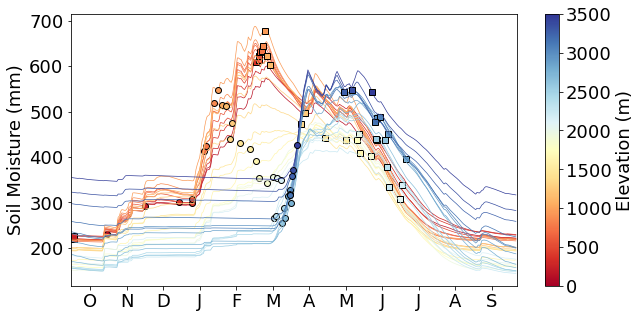

<Figure size 432x288 with 0 Axes>

In [51]:
plot_sm_elev_band3('Sierra Nevada')

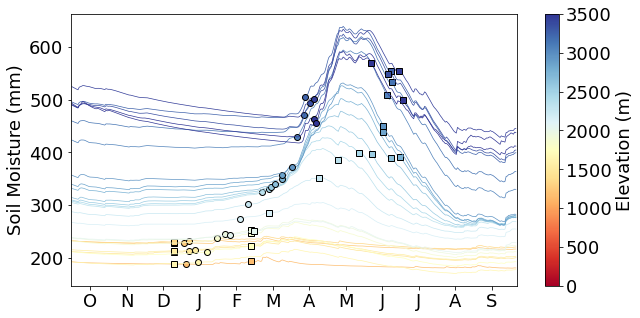

<Figure size 432x288 with 0 Axes>

In [54]:
plot_sm_elev_band3('Upper Colorado Region')

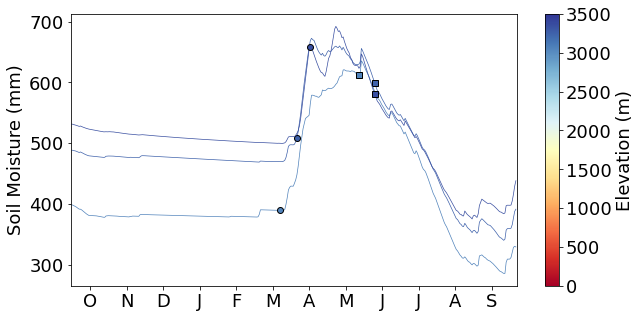

<Figure size 432x288 with 0 Axes>

In [55]:
plot_sm_elev_band3('9217900')

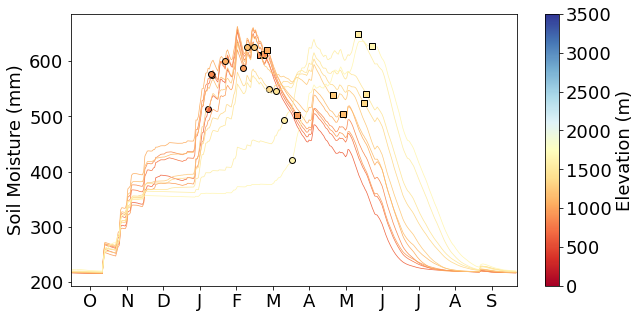

<Figure size 432x288 with 0 Axes>

In [50]:
plot_sm_elev_band3('11473900')